# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__:Eduardo Carriel Ordenes

* __Rol__:201810502-3

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [77]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from metrics_classification import *
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:
def resumen_por_columna(df,cols):
    pd_series = df[cols]
    
    # elementos distintos 
    l_unique = pd_series.unique()
    
    # elementos vacios
    
    l_vacios = pd_series[pd_series.isna()]
    
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
    
    return df_info

In [7]:
frames = []

for col in digits.columns:
    aux_df = resumen_por_columna(digits,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(digits)
df_info

,columna,unicos,vacios,% vacios
0,c00,1,0,0.0
1,c01,9,0,0.0
2,c02,17,0,0.0
3,c03,17,0,0.0
4,c04,17,0,0.0
...,...,...,...,...
60,c60,17,0,0.0
61,c61,17,0,0.0
62,c62,17,0,0.0
63,c63,17,0,0.0


### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [8]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

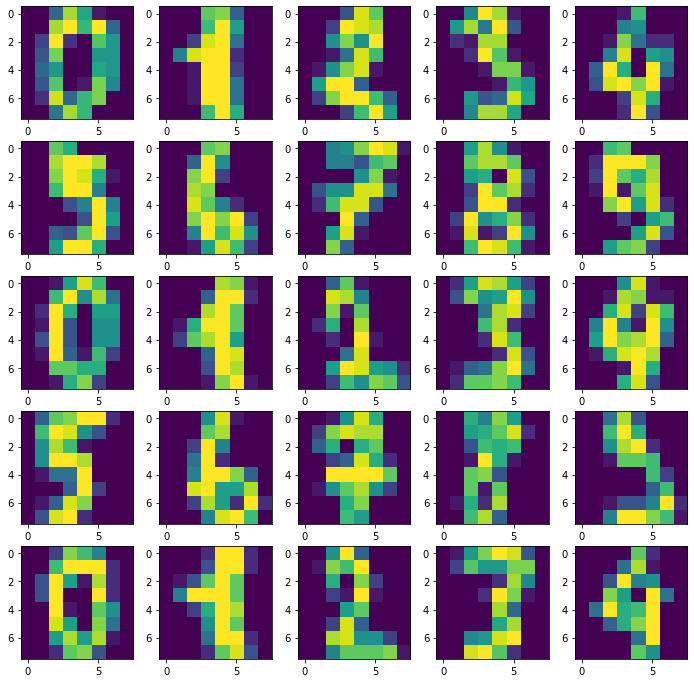

In [9]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
axs[0,0].imshow(digits_dict['images'][0])
axs[0,1].imshow(digits_dict['images'][1])
axs[0,2].imshow(digits_dict['images'][2])
axs[0,3].imshow(digits_dict['images'][3])
axs[0,4].imshow(digits_dict['images'][4])
axs[1,0].imshow(digits_dict['images'][5])
axs[1,1].imshow(digits_dict['images'][6])
axs[1,2].imshow(digits_dict['images'][7])
axs[1,3].imshow(digits_dict['images'][8])
axs[1,4].imshow(digits_dict['images'][9])
axs[2,0].imshow(digits_dict['images'][10])
axs[2,1].imshow(digits_dict['images'][11])
axs[2,2].imshow(digits_dict['images'][12])
axs[2,3].imshow(digits_dict['images'][13])
axs[2,4].imshow(digits_dict['images'][14])
axs[3,0].imshow(digits_dict['images'][15])
axs[3,1].imshow(digits_dict['images'][16])
axs[3,2].imshow(digits_dict['images'][17])
axs[3,3].imshow(digits_dict['images'][18])
axs[3,4].imshow(digits_dict['images'][19])
axs[4,0].imshow(digits_dict['images'][20])
axs[4,1].imshow(digits_dict['images'][21])
axs[4,2].imshow(digits_dict['images'][22])
axs[4,3].imshow(digits_dict['images'][23])
axs[4,4].imshow(digits_dict['images'][24])

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [78]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [79]:
df = pd.DataFrame(X, columns=digits.columns.drop('target'))
df['target'] = y
df.head() 

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


In [81]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

In [85]:
tlog.score(X_train, y_train)

1.0

In [82]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     33.69
Date:                Sun, 12 Dec 2021   Prob (F-statistic):          6.21e-228
Time:                        23:46:54   Log-Likelihood:                -2904.5
No. Observations:                1437   AIC:                             5933.
Df Residuals:                    1375   BIC:                             6260.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5836      0.489      7.329      0.0

In [84]:
tlog=DecisionTreeClassifier()
tlog.fit(X_train, y_train)

DecisionTreeClassifier()

In [86]:
y_true =  list(y_test)
y_pred = list(tlog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3, 9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3, 6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5, 7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4, 4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2, 7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5, 7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0, 6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3, 7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6, 4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5, 2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5, 5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7, 7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5, 5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2, 4, 6, 4, 3, 4, 5, 0, 5, 2, 1, 3, 1, 4, 1, 1, 7, 0, 1, 5, 2, 1, 2, 8, 7, 0

In [87]:
print('\nMatriz de confusion DecisionTreeClassifier():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion DecisionTreeClassifier():
 
[[29  0  0  0  3  1  0  0  0  0]
 [ 1 22  1  1  2  0  0  0  0  1]
 [ 0  0 25  3  2  0  1  1  1  0]
 [ 0  0  0 30  0  1  0  1  1  1]
 [ 0  0  0  1 41  2  1  1  0  0]
 [ 0  0  0  0  2 43  1  0  0  1]
 [ 0  0  0  0  2  0 33  0  0  0]
 [ 0  0  0  2  1  0  0 30  1  0]
 [ 0  2  0  1  2  2  0  1 20  2]
 [ 0  0  0  1  1  0  1  1  1 35]]


In [88]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.8556,0.8478,0.8681,0.8538


In [89]:
flog=RandomForestClassifier()
flog.fit(X_train, y_train)

RandomForestClassifier()

In [90]:
flog.score(X_train, y_train)

1.0

In [91]:
y_true =  list(y_test)
y_pred = list(flog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3, 9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3, 6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5, 7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4, 4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2, 7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5, 7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0, 6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3, 7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6, 4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5, 2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5, 5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7, 7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5, 5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2, 4, 6, 4, 3, 4, 5, 0, 5, 2, 1, 3, 1, 4, 1, 1, 7, 0, 1, 5, 2, 1, 2, 8, 7, 0

In [92]:
print('\nMatriz de confusion RandomForestClassifier():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion RandomForestClassifier():
 
[[32  0  0  0  1  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 44  1  0  0  2]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  1  0  0 28  0]
 [ 0  0  0  0  0  0  0  1  0 39]]


In [93]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.9722,0.9727,0.9751,0.9736


In [95]:
rlog = LogisticRegression()
rlog.fit(X_train, y_train)

C:\Users\javie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [96]:
rlog.score(X_train,y_train)

1.0

In [97]:
y_true =  list(y_test)
y_pred = list(rlog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3, 9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3, 6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5, 7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4, 4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2, 7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5, 7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0, 6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3, 7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6, 4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5, 2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5, 5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7, 7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5, 5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2, 4, 6, 4, 3, 4, 5, 0, 5, 2, 1, 3, 1, 4, 1, 1, 7, 0, 1, 5, 2, 1, 2, 8, 7, 0

In [98]:
print('\nMatriz de confusion LogisticRegression():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion LogisticRegression():
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  1  0  0 44  0  1  0  0  0]
 [ 0  0  1  0  0 44  1  0  0  1]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  1  0  0  0  0  1 38]]


In [99]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.9694,0.9722,0.9709,0.9714


In [100]:
slog = SVC()
slog.fit(X_train, y_train)

SVC()

In [101]:
slog.score(X_train,y_train)

0.9965205288796103

In [102]:
y_true =  list(y_test)
y_pred = list(slog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3, 9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3, 6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5, 7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4, 4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2, 7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5, 7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0, 6, 4, 3, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3, 7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6, 4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5, 2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5, 5, 1, 6, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7, 7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5, 5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2, 4, 6, 4, 3, 4, 5, 0, 5, 2, 1, 3, 1, 4, 1, 1, 7, 0, 1, 5, 2, 1, 2, 8, 7, 0

In [104]:
print('\nMatriz de confusion SVC():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion SVC():
 
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 46  1  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  0  0  0  0  0  0 29  1]
 [ 0  0  0  0  0  1  0  1  0 38]]


In [105]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.9861,0.9866,0.9872,0.9868


### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [ ]:
## FIX ME PLEASE

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [ ]:
## FIX ME PLEASE

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [ ]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [ ]:
## FIX ME PLEASE

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [10]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing['ocean_proximity']=housing['ocean_proximity'].replace({'NEAR BAY':0,'<1H OCEAN':1,'INLAND':2,'NEAR OCEAN':3,'ISLAND':4})
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


In [14]:
housing.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,1.464729
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,0.854226
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,1.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,2.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


In [15]:
frames = []

for col in housing.columns:
    aux_df = resumen_por_columna(housing,col)
    frames.append(aux_df)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(housing)
df_info

,columna,unicos,vacios,% vacios
0,longitude,844,0,0.000000
1,latitude,862,0,0.000000
2,housing_median_age,52,0,0.000000
3,total_rooms,5926,0,0.000000
4,total_bedrooms,1924,207,0.010029
5,population,3888,0,0.000000
6,households,1815,0,0.000000
7,median_income,12928,0,0.000000
8,median_house_value,3842,0,0.000000
9,ocean_proximity,5,0,0.000000


In [18]:
housing=housing.fillna(0.0)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


In [30]:
X = housing
X=housing[['longitude', 'latitude']]
Y = housing['ocean_proximity']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2)

In [31]:
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  20640
numero de filas train set     :  16512
numero de filas test set      :  4128


In [50]:
tlog=DecisionTreeClassifier()
tlog.fit(X_train, Y_train)

DecisionTreeClassifier()

In [51]:
tlog.score(X_train,Y_train)

1.0

In [52]:
y_true =  list(Y_test)
y_pred = list(tlog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 0, 2, 1, 1, 3, 2, 3, 0, 2, 3, 2, 0, 1, 1, 3, 0, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 0, 2, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 0, 1, 3, 1, 0, 2, 3, 1, 2, 0, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 3, 1, 2, 0, 1, 1, 1, 2, 3, 2, 0, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 3, 0, 1, 1, 2, 3, 2, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 2, 1

In [53]:
print('\nMatriz de confusion DecisionTreeClassifier():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion DecisionTreeClassifier():
 
[[ 468    1    0    0    0]
 [   0 1805   10    9    0]
 [   0   10 1306    0    0]
 [   4   14    0  500    0]
 [   0    0    0    0    1]]


In [54]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.9884,0.989,0.9905,0.9898


In [56]:
X= X.values
Y= Y.values

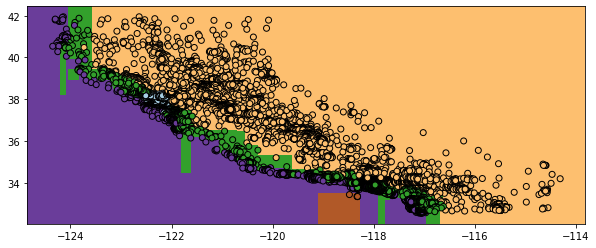

In [57]:
plt.figure(figsize=(10,4))

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tlog.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

In [59]:
flog=RandomForestClassifier()
flog.fit(X_train, Y_train)

RandomForestClassifier()

In [60]:
flog.score(X_train, Y_train)

1.0

In [61]:
y_true =  list(Y_test)
y_pred = list(flog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 0, 2, 1, 1, 3, 2, 3, 0, 2, 3, 2, 0, 1, 1, 3, 0, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 0, 2, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 0, 1, 3, 1, 0, 2, 3, 1, 2, 0, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 3, 1, 2, 0, 1, 1, 1, 2, 3, 2, 0, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 3, 0, 1, 1, 2, 3, 2, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 2, 1

In [62]:
print('\nMatriz de confusion RandomForestClassifier():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion RandomForestClassifier():
 
[[ 467    1    0    1    0]
 [   0 1806    8   10    0]
 [   0    5 1311    0    0]
 [   3   21    0  494    0]
 [   0    0    0    0    1]]


In [63]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

,accuracy,recall,precision,fscore
0,0.9881,0.9871,0.9902,0.9886


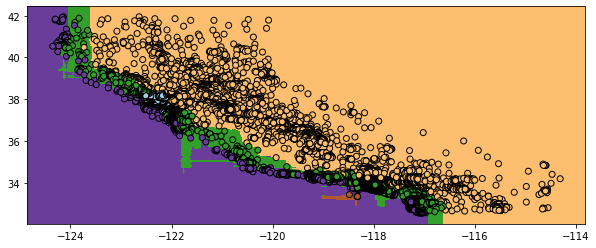

In [64]:
plt.figure(figsize=(10,4))

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = flog.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

In [65]:
rlog = LogisticRegression()
rlog.fit(X_train, Y_train)

C:\Users\javie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
rlog.score(X_train,Y_train)

0.5764898255813954

In [67]:
y_true =  list(Y_test)
y_pred = list(rlog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 0, 2, 1, 1, 3, 2, 3, 0, 2, 3, 2, 0, 1, 1, 3, 0, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 0, 2, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 0, 1, 3, 1, 0, 2, 3, 1, 2, 0, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 3, 1, 2, 0, 1, 1, 1, 2, 3, 2, 0, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 3, 0, 1, 1, 2, 3, 2, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 2, 1

In [68]:
print('\nMatriz de confusion LogisticRegression():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion LogisticRegression():
 
[[   0    0  469    0    0]
 [   0 1522  302    0    0]
 [   0  465  851    0    0]
 [   0  374  144    0    0]
 [   0    1    0    0    0]]


In [69]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

C:\Users\javie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,fscore
0,0.5749,0.2962,0.2252,0.2559


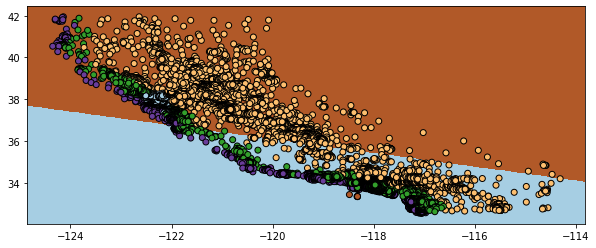

In [70]:
plt.figure(figsize=(10,4))

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = rlog.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()

In [71]:
slog = SVC()
slog.fit(X_train, Y_train)

SVC()

In [72]:
slog.score(X_train, Y_train)

0.5684956395348837

In [73]:
y_true =  list(Y_test)
y_pred = list(slog.predict(X_test))

print('Valores:\n')
print('originales: ', y_true)
print('predicho:   ', y_pred)

Valores:

originales:  [1, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 0, 2, 1, 1, 3, 2, 3, 0, 2, 3, 2, 0, 1, 1, 3, 0, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 0, 2, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 1, 0, 1, 3, 1, 0, 2, 3, 1, 2, 0, 2, 1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 0, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 3, 1, 2, 0, 1, 1, 1, 2, 3, 2, 0, 1, 2, 3, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 3, 0, 1, 1, 2, 3, 2, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 3, 0, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 2, 1

In [74]:
print('\nMatriz de confusion SVC():\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion SVC():
 
[[   0    0  469    0    0]
 [  20 1508  296    0    0]
 [   1  480  835    0    0]
 [  21  364  133    0    0]
 [   0    1    0    0    0]]


In [75]:
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
df_metrics

C:\Users\javie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,fscore
0,0.5676,0.2923,0.2245,0.254


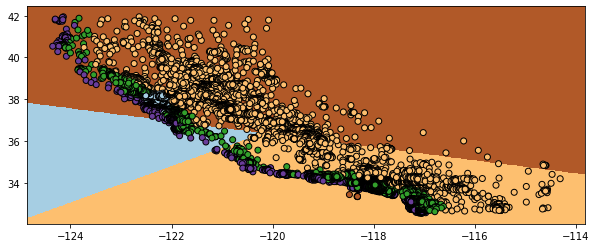

In [76]:
plt.figure(figsize=(10,4))

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = slog.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.show()